<a href="https://colab.research.google.com/github/bwoody13/MNIST-CNN-Classification/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Dataset for MNIST

In [ ]:
data_mean = 0.1307
data_std = 0.3081
init_trans = transforms.Compose([
    ToTensor(),
    Normalize((data_mean,), (data_std,))
])
dataset = MNIST(root='data/', train=True, download=True, transform=init_trans)
test_ds = MNIST(root='data/', train=False, download=True, transform=init_trans)

100%|██████████| 9912422/9912422 [00:00<00:00, 154209146.84it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29792349.69it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31555637.97it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 4581656.75it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Get visual for data

In [ ]:
examples = enumerate(DataLoader(dataset, 32, shuffle=True))
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 1, 28, 28])

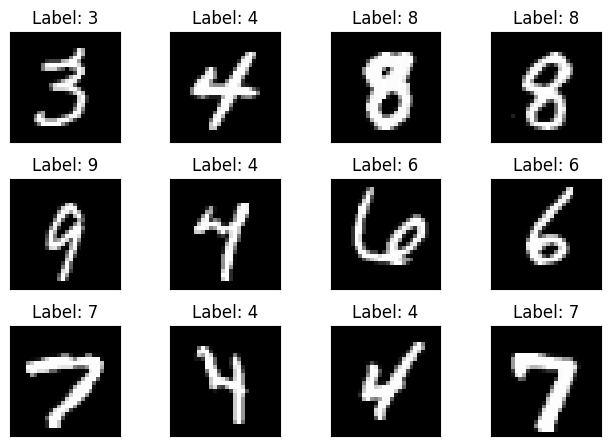

In [ ]:
fig = plt.figure()
for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

# Building the CNN

In [ ]:
class MyCNN(nn.Module):
    def __init__(
        self,
        epochs=10,
        learning_rate=0.01,
        batch_size=64,
        weight_decay=0,
        momentum=0,
        device=None
        ):
        super(MyCNN, self).__init__()
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.criterion = nn.CrossEntropyLoss()
        self.device = device if device != None else torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # Layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.35)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def make_optimizer(self):
        return optim.SGD(
            self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay, momentum=self.momentum
        )

## Training Functions

In [ ]:
def validate_model(model: MyCNN, validation_loader: DataLoader):
    model.eval()
    validation_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(model.device), target.to(model.device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(validation_loader.dataset)
    accuracy = correct / len(validation_loader.dataset)

    return validation_loss, accuracy

In [14]:
def train(model: MyCNN, train_loader: DataLoader, val_loader: DataLoader):
    model.to(model.device)
    train_losses = []
    train_counter = []

    optimizer = model.make_optimizer()

    # Adding transforms to data to make less dependent on training data
    additional_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=15)
    ])

    # For early stopping
    best_accuracy = 0.0
    earlystop_patience = 2
    earlystop_count = 0

    for epoch in range(model.epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            trans_inputs = additional_transforms(inputs)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(trans_inputs)

            # Calculate the loss
            loss = model.criterion(outputs, labels)

            # Backpropagation
            loss.backward()

            # Update the weights
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
                # Store train loss
                train_losses.append(running_loss / 100)
                train_counter.append(
                    epoch + (i / len(train_loader))
                )
                running_loss = 0.0


        # Validation
        validation_loss, validation_accuracy = validate_model(model, val_loader)
        print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy * 100:.2f}%')

        # Check Early Stopping
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            earlystop_count = 0
        else:
            earlystop_count += 1

        if earlystop_count > earlystop_patience:
            print(f"Early stopping! No improvement for the last {earlystop_patience} epochs.")
            break

    plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.xlabel('Epoch (values between ints indicate batches)')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Epoch')
    plt.show()


## Testing Functions

In [23]:
def test(model: MyCNN, test_loader: DataLoader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(model.device), target.to(model.device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

# Running the Model

In [17]:
model = MyCNN(momentum=0.9, learning_rate=0.01, weight_decay=1e-5)

In [12]:
num_workers = 2 if 'cuda' in model.device.type else 0
pin_memory = True if 'cuda' in model.device.type else False

train_loader = DataLoader(train_dataset, model.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, model.batch_size)
test_loader = DataLoader(test_ds, model.batch_size)

Epoch 1, Batch 100, Loss: 1.0506
Epoch 1, Batch 200, Loss: 0.3263
Epoch 1, Batch 300, Loss: 0.2520
Epoch 1, Batch 400, Loss: 0.1979
Epoch 1, Batch 500, Loss: 0.1897
Epoch 1, Batch 600, Loss: 0.1607
Epoch 1, Batch 700, Loss: 0.1398
Epoch 1, Batch 800, Loss: 0.1379
Validation Loss: 0.0648, Validation Accuracy: 98.05%
Epoch 2, Batch 100, Loss: 0.1266
Epoch 2, Batch 200, Loss: 0.1311
Epoch 2, Batch 300, Loss: 0.1089
Epoch 2, Batch 400, Loss: 0.1064
Epoch 2, Batch 500, Loss: 0.1013
Epoch 2, Batch 600, Loss: 0.1176
Epoch 2, Batch 700, Loss: 0.1078
Epoch 2, Batch 800, Loss: 0.1012
Validation Loss: 0.0424, Validation Accuracy: 98.68%
Epoch 3, Batch 100, Loss: 0.0896
Epoch 3, Batch 200, Loss: 0.0979
Epoch 3, Batch 300, Loss: 0.0869
Epoch 3, Batch 400, Loss: 0.0879
Epoch 3, Batch 500, Loss: 0.0778
Epoch 3, Batch 600, Loss: 0.0822
Epoch 3, Batch 700, Loss: 0.0849
Epoch 3, Batch 800, Loss: 0.0868
Validation Loss: 0.0375, Validation Accuracy: 98.83%
Epoch 4, Batch 100, Loss: 0.0795
Epoch 4, Batch 2

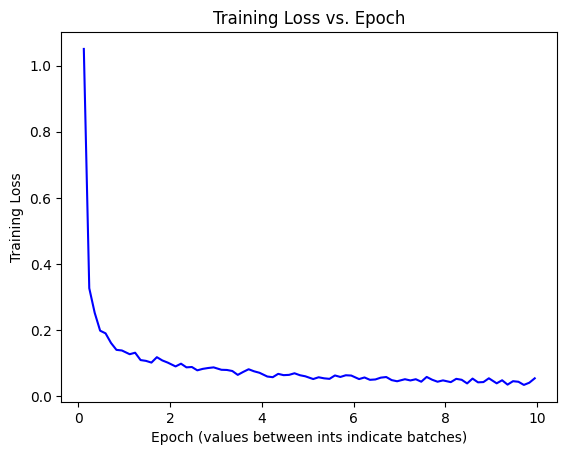

In [18]:
train(model, train_loader, val_loader)

In [24]:
test(model, train_loader)


Test set: Average loss: 0.0142, Accuracy: 53774/54000 (99.58%)


In [25]:
test(model, test_loader)


Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)


# Saving / Reloading Model

In [29]:
# Note parent dir must exist and you must mount to drive to save this way.
# You can just save to root and it will make a tmp file if you do not want to mount drive and set up additional files
def save_model(model, name, parent_dir="drive/MyDrive/Colab Notebooks/MNIST/models"):
    torch.save(model, f"{parent_dir}/{name}.pth")

In [27]:
def load_model(name, parent_dir="drive/MyDrive/Colab Notebooks/MNIST/models"):
    model = torch.load(f"{parent_dir}/{name}.pth")
    model.eval()
    return model

In [28]:
save_model(model, "99_29-Test")

In [ ]:
loaded_model = load_model("99_29-Test")

In [ ]:
test(loaded_model, test_loader)